# RES Cleaning

This notebook walks through how the RES articles were sorted into categories of articles and non-articles.

## Load Libraries

In [9]:
from tokenize import Ignore
from numpy import NaN
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
import multiprocessing as mp
import time
from os import path
import os
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import matplotlib.pyplot as plt    

## Load Files

Replace the file paths below to match local file paths. Note: comment out files that are not available eg: datadumps.

In [7]:
masters = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\Master lists\\RES_master.xlsx")
pivots = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\pivots\\RES_pivots.xlsx")
scopus = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\Scopus\\RES_SCOPUS.xlsx")
datadump = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_datadump.xlsx")

pd.set_option('display.max_colwidth', None)

## Create File Names

In [3]:
authors="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_authors.xlsx"
non_auth="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_Nauthors.xlsx"
saveas="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_processed.xlsx"
reviews="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_reviews.xlsx"
misc="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_misc.xlsx"
conf="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_conf.xlsx"

## Some random checks on the masters list

My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [55]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1])

,title
front matter,297
back matter,278
volume information,73
accepted manuscripts,9
periodicals received,8
books and monographs received,8
editorial announcement,8
comment,5
editorial,5
introduction,4


Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [56]:
temp1=masters[masters['authors'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp1)

,title
front matter,297
back matter,278
volume information,73
accepted manuscripts,9
books and monographs received,8
periodicals received,8
books and periodicals received,3
announcement,3
introduction,2
errata: neutral inventions and production functions,2


In [57]:
#pd.DataFrame(masters[masters['content_type'].isna()]['title'].str.lower().value_counts())
#masters[masters['title'].str.lower().str.match(r'(^|: )report of the')]
#masters[masters['title'].str.lower().str.match(r'(^|.*: )report of the')]
#masters.loc[masters['title'].str.lower().str.match(r'^combined references(.*)')==True,'content_type']='MISC'

# this is a random panel for testing code

,Unnamed: 0,stable_url,authors,title,abstract,content_type,issue_url,pages


Notice that titles with duplicates of greater or equal to 4 are miscellaneous items and so they are classified in bulk

In [59]:
temp2=masters[(masters['content_type'].isna()==True)]['title'].str.lower().value_counts()
removal=list(temp2[temp2>=4].index)
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

Classify some titles via regex

In [60]:
masters.loc[masters['title'].str.lower().str.contains('books and periodicals')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^editorial')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^announcement')==True,'content_type']='MISC'
masters.loc[masters['title'].str.strip().str.len()<4,'content_type']='MISC'
#masters[masters.content_type=='MISC']


In [61]:
scopus.rename(columns = {'abstract':'abstract2', 'title':'title2', 'authors':'authors2'}, inplace = True)
scopus['pages2']=scopus['pages']
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = NaN  

## Classifying other content

In [62]:
sum(masters.content_type.isna())
#masters.shape[0]

3259

In [63]:
masters.loc[masters['authors'].str.lower().str.match(r'^review(ed|) by(.*)')==True,'content_type']='Review' #reviews
masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.authors.isna()==True),'content_type']='Review2' 
#possible reviews that don't have author names
masters[(masters['content_type']=='Review2') | (masters['content_type']=='Review')].shape[0] #reviews

0

In [64]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?).*comment.*$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*comment$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(a further|further) comment.*$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0] 
#comments

55

In [65]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

15

In [66]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?|).*rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]


9

In [67]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]


0

In [68]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

3180

In [2]:
# block for testing regex patterns
#masters[masters['title'].str.lower().str.match(r'^\washington notes$')==True]
#masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True]
#masters[masters.content_type=='Discussion'].shape[0]

## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles. The next code block separates special issues (S) from normal issues (N)

In [71]:
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()

N    309
Name: type, dtype: int64

Merge masterlist and pivot list

In [72]:
result = pd.merge(masters, pivots[['issue_url','year','volume','issue','journal','type']], how="left", on=["issue_url", "issue_url"])

## Summary

In [73]:
pd.DataFrame(result.content_type.value_counts())

,content_type
Article,3180
MISC,711
Comment,55
Reply,15
Rejoinder,9


In [74]:
pd.DataFrame(result[result.year>1939].content_type.value_counts())

,content_type
Article,3036
MISC,670
Comment,54
Reply,11
Rejoinder,7


In [75]:
pd.DataFrame(result[(result.year>1939) & (result.year<2011)].content_type.value_counts())

,content_type
Article,2608
MISC,606
Comment,54
Reply,11
Rejoinder,7


In [76]:
result.to_excel(saveas, index=False)

## This section aims to match up Scopus records and Jstor articles
If an article's affiliations, citations or abstracts are recorded on Scopus. matching up the Scopus data is useful for comparing the textual accuracy of OCR parsers. I use volume, issue, year and page numbers which are common to both the scopus data and the Jstor metadata to match articles. 

Then I use a sequence comparison between the journal titles of the matched articles to decide if the scopus data has been matched correctly. If the match ratio is below 70%, the title is investigated and if wrong, the scopus data for that matched article is either corrected or discarded. 

The next section reads in the processed data previously saved. Please make sure the path in the variable 'cleaned' matches the file path on your local machine.

In [164]:
cleaned=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\processed\\RES_processed.xlsx')
cleaned['volume']=cleaned['volume'].astype(int)
scopus['pages']=scopus['pages'].str.strip()
#print(scopus.shape)
#cleaned.year.unique()

This is the number of entries on Scopus

In [165]:
#Note that we only have data up to 2018 in the masterlists because of the moving wall on JSTOR
print(sum(scopus['year']<2019))
print(scopus.shape)

2844
(2992, 14)


Merge on year, issue, volume and pages.

In [166]:
Merged=pd.merge(cleaned, scopus, on=['year', 'issue','volume','pages'], how='left')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Check how many of the scopus entries matched.

In [167]:
sum(Merged['title_y'].isna()==False)

2698

Quick maths: There are 3970 total documents for Review of econ. studies (RES) between, 3180 of these are actual articles. Scopus matched up to 2698 entries in the RES masterlist. This means there is 146 entries in Scopus that do not match up to something in the masterlists. And atleast 1272 entries in the masterlist without scopus records. Conclusion: 60% coverage ain't too bad! Now let's see if there is actual references and affiliations or did Scopus just bullshit us all.

Consider the titles that have a less than 70% match.

In [168]:
count=0
for m in Merged.index:
    
    if(pd.isna(Merged.iloc[m]['title_y'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title_x'].lower(), Merged.iloc[m]['title_y'].lower()).ratio()
        if((ratio<0.7) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            if pd.isna(Merged.iloc[m]['authors_x'])==False:
                A_ratio=SequenceMatcher(None, Merged.iloc[m]['authors_x'].lower(), Merged.iloc[m]['authors_y'].lower()).ratio()
                print(A_ratio)
            else:
                print('Author issue')
                print(Merged.iloc[m]['authors_x'])
                print(Merged.iloc[m]['authors_y'])
            print(Merged.iloc[m]['stable_url'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            print('issue: '+str(Merged.iloc[m]['issue']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title_x'])
            print('scopus: '+Merged.iloc[m]['title_y'])
            print('jstor: '+str(Merged.iloc[m]['authors_x']))
            print('scopus: '+str(Merged.iloc[m]['authors_y']))
            print('scopus index: '+str(scopus[scopus['title']==Merged.iloc[m]['title_y']].index))
            print(m)
            print()
print(count)

2016
0.6098654708520179
Author issue
nan
Meng, X.--a--
Qian, N.--b--
Yared, P.--c-- 
https://www.jstor.org/stable/43869567
vol: 83
issue: 3.0
pages: 1296
jstor: Erratum: The Institutional Causes of China's Great Famine, 1959-1961
scopus: Erratum: "The institutional causes of China's Great Famine, 1959-1961" [Review of Economic Studies, 82, 4, (2015), (1568-1611)]. Doi: 10.1093/restud/rdv016
jstor: nan
scopus: Meng, X.--a--
Qian, N.--b--
Yared, P.--c-- 
scopus index: Int64Index([2694], dtype='int64')
166

2013
0.5858585858585859
0.4444444444444444
https://www.jstor.org/stable/43551460
vol: 80
issue: 3.0
pages: 1178-1214
jstor: Estimating Ethnic Preferences Using Ethnic Housing Quotas in Singapore
scopus: Estimating ethnic preferences
jstor: MAISY WONG
scopus: Wong, M.
scopus index: Int64Index([2474], dtype='int64')
341

2013
0.5991189427312775
Author issue
nan
nan
https://www.jstor.org/stable/43551504
vol: 80
issue: 2.0
pages: 840-843
jstor: Erratum: Endogenous Games and Mechanisms: Sid

1946
0.22784810126582278
0.5
https://www.jstor.org/stable/2296089
vol: 14
issue: 2.0
pages: 95-97
jstor: [A New View of the Economics of International Readjustment]: A Comment
scopus: A comment
jstor: R. F. Harrod
scopus: Harrod, R.F.
scopus index: Int64Index([17, 309, 311, 433, 1029], dtype='int64')
3653

1945
0.21818181818181817
Author issue
nan
Barna, T.
https://www.jstor.org/stable/2296042
vol: 13
issue: 2.0
pages: 84-108
jstor: Periodicals
scopus: Rebuilding london: A survey in stepney, 1946
jstor: nan
scopus: Barna, T.
scopus index: Int64Index([316], dtype='int64')
3669

1940
0.23684210526315788
0.45454545454545453
https://www.jstor.org/stable/2967420
vol: 8
issue: 1.0
pages: 64-65
jstor: [Complementarity and Interrelations of Shifts in Demand]: A Comment
scopus: A comment
jstor: J. R. Hicks
scopus: Hicks, J.R.
scopus index: Int64Index([17, 309, 311, 433, 1029], dtype='int64')
3760

1940
0.6176470588235294
0.48
https://www.jstor.org/stable/2967407
vol: 7
issue: 3.0
pages: 196-201

This code is used to search for title or author matches in the jstor masterlists to find entries to correct the scopus data.

In [111]:
#search='Bargaining With Two-Sided Incomplete Information: An Infinite Horizon Model With Alternating Offers'
#search='Acyclic choice without the pareto principle'
#search='On Bayesian Implementable Allocations'
#search='How fast do rational agents learn'
search='A. P. lerner'
for i in cleaned.index:
    if pd.isna(cleaned.iloc[i]['authors'])==False:
        c=SequenceMatcher(None, cleaned.iloc[i]['authors'].lower(), search).ratio()
        if c>0.7:
            print(cleaned.iloc[i])

Now let's do some manual corrections.

In [169]:

#scopus index 1170 wrong citation altogether in scopus drop from scopus set
scopus.drop(1170, axis=0, inplace=True) #uncomment later for full run
#these recorded incorrect pages
scopus.loc[1252,'pages']='693-699'
scopus.loc[1505,'pages']='175-192'
scopus.loc[1503,'pages']='193-208'
scopus.loc[1608, 'pages']='329-347'


There are some issues in the masterlists caused by the scraper logic. If there was a NaN in the page reference, the previous entries' page numbers were used which duplicated the uniqueness of year-volume-issue-pages. This is to be corrected now.

In [170]:
#get a dataframe of counts
x=pd.DataFrame(cleaned[['year','volume','issue','pages']].value_counts()).reset_index()
k=x[x[0]>1]
k

,year,volume,issue,pages,0
0,1945,13,2.0,84-108,3
1,1964,31,3.0,220) https://doi.org/10.2307/229591,3
2,1987,54,4.0,701-703,2
3,1982,49,4.0,669-674,2
4,1934,1,3.0,236,2
5,1941,8,3.0,188,2
6,1969,36,3.0,395-398,2
7,1996,63,4.0,677-680,2
8,1966,33,4.0,i-iv,2
9,1995,62,4.0,665-668,2


Now let's remove the duplicates and text issues. The first if statement resets the page numbers to remove leftover doi references. The second searches for duplicates and if it is a "Front Matter" or duplicates the pages of an actual article then the pages are set to None.

In [171]:
count=0
for i in cleaned.index:
    m=cleaned.iloc[i]
    if 'http' in str(cleaned.loc[i, 'pages']):
        cleaned.loc[i, 'pages']=cleaned.loc[i, 'pages'].split(')')[0]
    if sum((k['year']==m['year']) & (k['volume']==m['volume']) & (k['issue']==m['issue']) & (k['pages']==m['pages']))==1:
        if m.title.strip()=='Front Matter':
            cleaned.loc[i,'pages']=None
        if pd.isna(m.authors)==False:
            temp=cleaned[(cleaned['year']==m['year']) & (cleaned['volume']==m['volume']) & (cleaned['issue']==m['issue']) & (cleaned['pages']==m['pages'])]
            for j in temp.index:
                if pd.isna(temp.loc[j, 'authors'])==True:
                    cleaned.loc[j,'pages']=None
        count+=1
        #print(m)

print(count)

69


Re-merge the scopus data and the cleaned masterlists

In [172]:
Merged=pd.merge(cleaned, scopus, on=['year', 'issue','volume','pages'], how='left')

Check for whether there is an issue in document type and correct it.

In [173]:
pd.DataFrame(Merged[Merged['document type'].str.len()>100])
Merged.loc[170,'document_type']='Article'
Merged.loc[174,'document_type']='Article'

Note: the datadump does not have any references for res. So merged data is saved directly after renaming.

In [174]:
Merged.rename(columns = {'authors_x':'Jstor_authors', 'title_x':'Jstor_title', 'abstract_x':'Jstor_abstract', 'journal_x':'Jstor_journal', 'authors_y':'scopus_authors','title_y':'scopus_title', 'abstract_y':'scopus_abstract', 'journal_y':'scopus_journal' }, inplace = True)

saving...

In [175]:
Merged.to_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_M_sco_du.xlsx', index=False)

# Merged dataset field description

This is a description of fields in the Merged dataset that combines JPE masterlist, pivot list, Scopus data pre-2018. The Merged dataset is stored in RES_M_sco_du.xlsx. Note that RES does not contain any reference data scraped from JSTOR.

    'stable_url' : JSTOR url for article 
    'Jstor_authors' : Author names recorded by JSTOR
    'Jstor_title' : Title of article recorded by JSTOR
    'Jstor_abstract' : abstract recorded by JSTOR nb: this is blank at the moment
    'content_type' : Article type determined during cleaning. Includes MISC for miscellaneous, Reviews, Note, Comment, Rejoinder and Article categorizations
    'issue_url' : url of issue article belongs to on JSTOR
    'pages' : pages as recorded by JSTOR
    'year' : Year of publication recorded by JSTOR
    'volume' : Volume of article recorded by JSTOR
    'issue' : issue of article recorded by JSTOR
    'Jstor_journal' : journal name JSTOR
    'type' : Type of issue determined during cleaning. S for special issue. N for normal issue
    'scopus_authors' : Author names recorded by Scopus
    'scopus_title' : Title recorded by Scopus
    'scopus_journal' : Journal name recorded by Scopus
    'DOI' : DOI recorded by scopus
    'affiliations' : affiliations of authors as recorded by scopus
    'scopus_abstract' : abstract of article recorded by scopus
    'citations' : citations of article recorded by scopus
    'document type' : Article type recorded by scopus, may differ from that in cleaning
    'index keywords' : from scopus
    'author keywords' : from scopus 

In [3]:
Merged=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\RES_M_sco_du.xlsx')

In [4]:
inv=Merged[(Merged['year']<=1971) & (Merged['year']>=1940)&(Merged['content_type']!='MISC')&(Merged['content_type']!='Review')&(Merged['content_type']!='Discussion')]
inv.shape

(805, 24)

In [5]:
Merged.content_type.unique()

array(['MISC', 'Article', 'Comment', 'Reply', 'Rejoinder'], dtype=object)

### Plots of counts
Exploratory analysis of available data in scopus and datadumps.

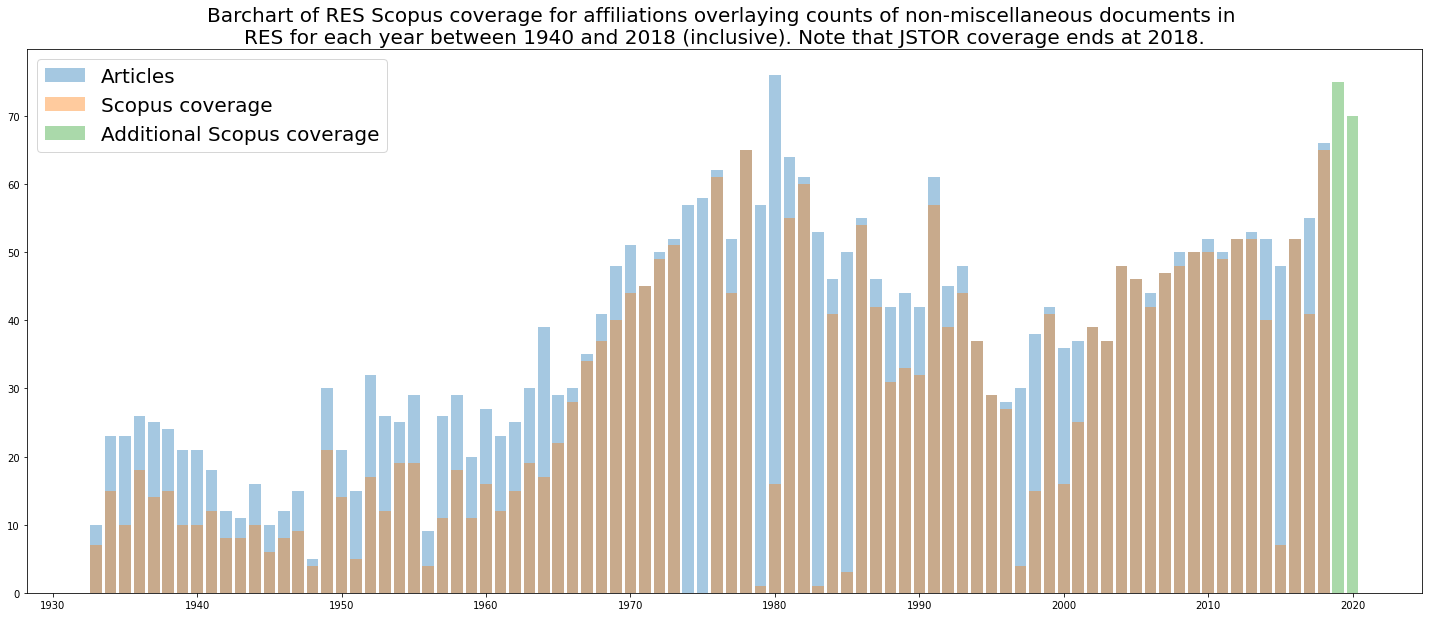

In [10]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2018)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of RES Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nRES for each year between 1940 and 2018 (inclusive). Note that JSTOR coverage ends at 2018.', fontsize=20)
plt.xticks(np.arange(1930, 2030, 10))
plt.legend(prop={'size': 20})


Some years of coverage are almost complete, it may not be necessary to use OCR to extract affiliations. I propose there's only a real point to set up the OCR if there if more than 80% of the articles in a issue are missing affiliations. 

Consider the missing counts of articles per issue by getting counts of total per issue and scopus affiliations per issue.

In [275]:
sc_aff=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')][['year','volume','issue']].value_counts()
js_aff=Merged[(Merged['content_type']!='MISC')][['year','volume','issue']].value_counts()

Create a dataframe of counts of missing article affiliations per issue and merge that with the total articles per issue and calculate the percentage of missing article affiliations.

In [291]:
difference=pd.DataFrame(js_aff-sc_aff).reset_index()  #get difference
difference=pd.merge(difference, js_aff.reset_index(), on=['year', 'issue','volume'], how='right').sort_values(['year','issue','volume'])
difference['retrieval_req']=difference['0_x']/difference['0_y']
difference.rename(columns = {'0_x':'missing', '0_y':'total'}, inplace = True)
difference['retrieval_req'] = difference['retrieval_req'].fillna(1)

difference[difference['year']>=1940] # if missing is NaN that means the whole issue is missing.


,year,volume,issue,missing,total,retrieval_req
242,1940,8,1.0,5.0,8,0.625000
301,1940,7,2.0,2.0,5,0.400000
244,1940,7,3.0,4.0,8,0.500000
281,1941,9,1.0,3.0,6,0.500000
266,1941,8,2.0,1.0,7,0.142857
296,1941,8,3.0,2.0,5,0.400000
258,1942,10,1.0,3.0,7,0.428571
293,1942,9,2.0,1.0,5,0.200000
284,1943,11,1.0,3.0,6,0.500000
299,1943,10,2.0,0.0,5,0.000000


There are on average 10 articles per issue. And for older papers, there are only 5 to 7 articles in the issue. Hence, if there are only one or two missing affiliations in that issue it makes sense to collect them manually since setting up the rules for OCR to find the affiliations in just one paper is more time consuming than looking it up.

In [290]:
check_aff=Merged[(Merged['content_type']!='MISC')&(Merged['year']>=1940)&(Merged['year']<=2010)] #restrict to 1940 to 2010
print(sum(check_aff['affiliations'].isnull())) #number of missing in time period
print(check_aff.shape[0]) #total articles in 1940 to 2010
print(1-(sum(check_aff['affiliations'].isnull())/check_aff.shape[0])) #percentage coverage
sum(difference[difference['retrieval_req']<0.5]['missing']) #manual work expected

746
2681
0.721745617306975


250.0

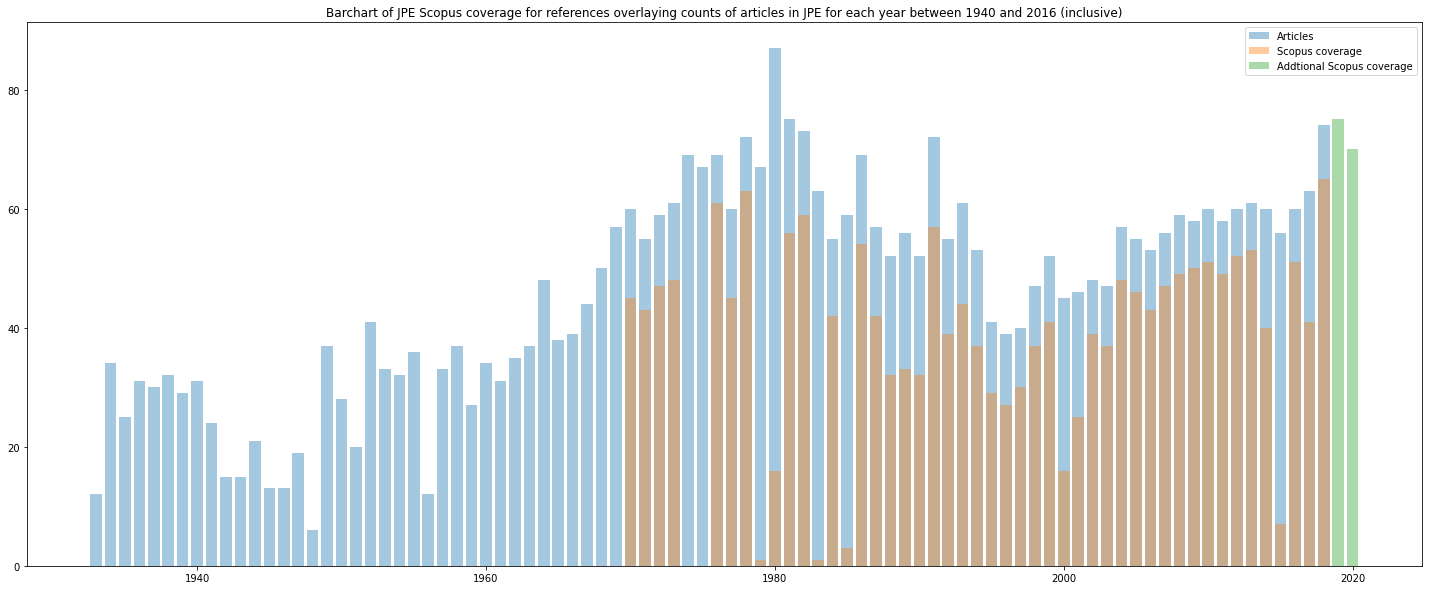

In [224]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')

dta4=Merged[(Merged['citations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Scopus coverage')
dta5=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2018)]['year'].value_counts()
plt.bar(dta5.index, dta5, alpha=0.4, label='Addtional Scopus coverage')
plt.title('Barchart of RES Scopus coverage for references overlaying counts of non-miscellaneous documents in RES for each year before 2018 (inclusive)')
plt.xticks(np.arange(1930, 2030, 10))
plt.legend()

In [270]:
check_ref=Merged[(Merged['content_type']!='MISC')&(Merged['year']>=1940)&(Merged['year']<=2010)] # restrict between 1940 and 2010
print(sum(check_aff['citations'].isnull())) # number of missing ref articles 
print(check_aff.shape[0]) # total number of articles
print(1-(sum(check_aff['citations'].isnull())/check_aff.shape[0])) #percentage coverage

1166
2681
0.5650876538604999
